In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import matplotlib.patches as mpl_patches
%matplotlib inline

In [2]:
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [3]:
data = pd.read_csv('../../merge/data_with_features.txt',sep='\t')
uncorrected_data = pd.read_csv('../../merge/no_GC_correction_data_with_features.txt',sep='\t')
stat_data = pd.read_csv('../statistical_tests/tfx_correlation_statistics.txt',sep='\t')
stat_data = stat_data.set_index('site_name')

2 2 191
2 2 191


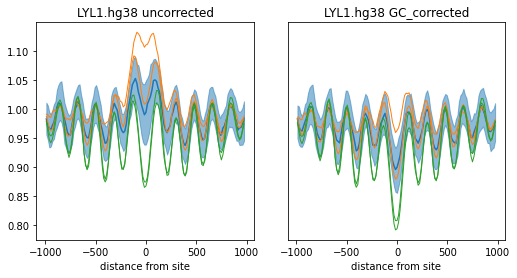

In [4]:
#top panel
fig,axes = plt.subplots(1,2, figsize=(9,4), sharey=True)
site_name = 'LYL1.hg38'

#plot median +/- IQR
for i,(df,title) in enumerate(zip([uncorrected_data, data],['uncorrected','GC_corrected'])):
    ax = axes[i]
    deep_data = df[~(df['sample'].str.contains('ULP')) & (df['sample'].str.contains('deep')) & (df['site_name']==site_name)]
    HD_data = df[(df['sample'].str.contains('HD')) & (df['site_name']==site_name)]
    ULP_data = df[df['sample'].str.contains('ULP') & (df['site_name']==site_name)]
    ULP_data = ULP_data[(ULP_data['tumor_fraction']>=0.1) & (ULP_data['ulp_wgs_coverage']>=0.1) & (ULP_data['merged_updated_ER_status_binary']!='none')]
    print(len(deep_data),len(HD_data),len(ULP_data['sample'].unique()))

    #plot ULP coverage
    ax.plot(plot_columns,ULP_data[str_plot_columns].median(), color = 'tab:blue', label = 'MBC ULP median\n+/- IQR')
    ax.fill_between(plot_columns,np.percentile(ULP_data[str_plot_columns], 25, axis = 0), np.percentile(ULP_data[str_plot_columns], 75, axis = 0), color = 'tab:blue', alpha = 0.5)

    #plot deepWGS coverage
    ax.plot(plot_columns,deep_data[str_plot_columns].T, color = 'tab:orange', linewidth = 1)
    ax.plot(plot_columns,HD_data[str_plot_columns].T, color = 'tab:green', linewidth = 1)
    
    ax.plot(0,1, color = 'tab:orange', label = 'MBC deepWGS', linewidth = 1)
    ax.plot(0,1, color = 'tab:green', label = 'HD deepWGS', linewidth = 1)

    #add legend and labels
    ax.set_title(site_name+' '+title)
    ax.set_xlabel('distance from site')

axes[0].set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
axes[1].set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
axes[1].tick_params(left = False)  
fig.subplots_adjust(wspace = 0.0)
fig.savefig('profiles_before_and_after_correction.pdf')

2 2 191
uncorrected
pearson r: 0.31
pearson pval: 1.25E-05
(0.31030448578193315, 1.250056717142918e-05)
2 2 191
GC_corrected
pearson r: 0.63
pearson pval: 2.03E-22
(0.6288328151875361, 2.031627922575653e-22)


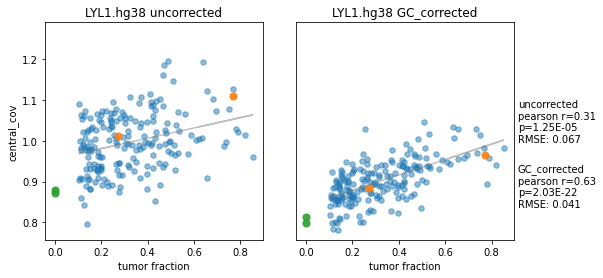

In [6]:
#bottom panel
fig,axes = plt.subplots(1,2, figsize=(9,4), sharey=True)
site_name = 'LYL1.hg38'
feature = 'central_cov'
marker_size = 30

labels = []

for i,(df,title) in enumerate(zip([uncorrected_data, data],['uncorrected','GC_corrected'])):
    ax = axes[i]
    deep_data = df[~(df['sample'].str.contains('ULP')) & (df['sample'].str.contains('deep')) & (df['site_name']==site_name)]
    HD_data = df[(df['sample'].str.contains('HD')) & (df['site_name']==site_name)]
    ULP_data = df[df['sample'].str.contains('ULP') & (df['site_name']==site_name)]
    ULP_data = ULP_data[(ULP_data['tumor_fraction']>=0.1) & (ULP_data['ulp_wgs_coverage']>=0.1) & (ULP_data['merged_updated_ER_status_binary']!='none')]
    print(len(deep_data),len(HD_data),len(ULP_data['sample'].unique()))
    
    ax.scatter(ULP_data['tumor_fraction'],ULP_data[feature], label = 'MBC ULP n='+str(len(ULP_data)), alpha = 0.5, s = marker_size)
    ax.scatter(deep_data['tumor_fraction'],deep_data[feature], label = 'MBC deepWGS', alpha = 0.9, s = 50)
    ax.scatter(HD_data['tumor_fraction'],HD_data[feature], label = 'HD deepWGS', alpha = 0.9, s = 50)
    
    #plot line of best fit
    lin_reg_slope = stat_data.loc[site_name]['lin_reg_slope_'+feature+'_'+title]
    lin_reg_intercept = stat_data.loc[site_name]['lin_reg_intercept_'+feature+'_'+title]
    fit_line = lin_reg_slope*ULP_data['tumor_fraction']+lin_reg_intercept
    ax.plot(ULP_data['tumor_fraction'],fit_line, color= 'grey', alpha = 0.5, label = 'best fit')
    
    ax.set_xlabel('tumor fraction')
    ax.set_title(site_name+' '+title)
    
    pearson_r = stat_data.loc[site_name]['pearson_r_'+feature+'_'+title]
    pearson_pval = stat_data.loc[site_name]['pearson_pval_'+feature+'_'+title]
    RMSE = stat_data.loc[site_name]['lin_reg_RMSE_'+feature+'_'+title]

    print(title)
    print("pearson r:",np.round(pearson_r,2))
    print("pearson pval:",'{:.2E}'.format(pearson_pval))
    
    #check that the imported stat data matches the data here
    print(pearsonr(ULP_data['tumor_fraction'],ULP_data[feature]))
    
    ylim = ax.get_ylim()
    ylim_range = ylim[1]-ylim[0]
    ylim = (ylim[0]-ylim_range*0.02,ylim[1]+ylim_range*0.08)
    ax.set_ylim(ylim)
    
    #add the stat text

    label = title+\
    '\npearson r='+str(np.round(pearson_r,2))+\
    '\np='+'{:.2E}'.format(pearson_pval)+'\nRMSE: '+'{:.3f}'.format(RMSE)
    labels.append(label)
    #l1 = ax.legend(handles,labels, frameon=False, loc='upper left')

axes[0].set_ylabel(feature)
axes[0].set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
axes[1].set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
axes[1].tick_params(left = False)  
fig.subplots_adjust(wspace = 0)


axes[1].text(1.02,.45,labels[0],transform=ax.transAxes)
axes[1].text(1.02,.15,labels[1],transform=ax.transAxes)


fig.savefig('scatter_before_and_after_correction.pdf')